In [1]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from natsort import natsorted

from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm

from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist


import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz

from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread


In [20]:
def load_data_png(path_num,path_all = False):
    if path_all:
        path = path_all
    else:
        path = f'registered/{path_num}/'
    pic_paths = []
    for i in os.listdir(path):
        if i.endswith('.dcm') or i.endswith('.tiff') or i.endswith('.PNG'):
            pic_paths.append(i)
    pic_paths = natsorted(pic_paths)

    temp_img = cv2.imread(path+pic_paths[0],cv2.IMREAD_UNCHANGED) 
    imgs_from_folder = np.zeros((len(pic_paths),temp_img.shape[0],temp_img.shape[1]))
    # imgs_from_folder = []
    for i,j in enumerate(pic_paths):
        aa = cv2.imread(path+j,cv2.IMREAD_UNCHANGED)
        imgs_from_folder[i] = aa.copy()
    imgs_from_folder = imgs_from_folder.astype(np.float32)
    return imgs_from_folder

def load_data_dcm(scan_num,crop=False):
    path = f'{scan_num}/'
    pic_paths = []
    for i in os.listdir(path):
        if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
            pic_paths.append(i)
    pic_paths = np.array(natsorted(pic_paths))
    fst = dicom.dcmread(path+pic_paths[0]).pixel_array

    data = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
    for i,j in enumerate(pic_paths):
        data[i] = dicom.dcmread(path+j).pixel_array
    data = (min_max(data)*((2**8)-1)).astype(np.uint8)
    if crop:
        cropped_data = crop_data(data)
        return cropped_data
    else:
        return data

def crop_data(data):
    cropped_data = data[:,360:380,:]
    return cropped_data


def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    # mov_mask = ants.from_numpy(moving_mask.astype(np.float64))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation',
                        aff_iterations=(1100, 1200, 1000, 1000))
    # reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
    return reg['fwdtransforms']


# def mse_fun_tran(shif,x,y):
#     tform = AffineTransform(translation=(0,shif[0]))
#     warped = warp(x, tform,order=3)
#     return -ncc(y,warped)


def ncc(a,b):
    # print(np.linalg.norm(a),np.linalg.norm(b))
    a = a / np.linalg.norm(a) if np.linalg.norm(a)!=0 else a / 10
    b = b / np.linalg.norm(b) if np.linalg.norm(b)!=0 else b / 10
    # print(np.correlate(a.flatten(), b.flatten(), mode = 'full'))
    return np.correlate(a.flatten(), b.flatten())

def min_max(data1):
    if np.all(data1 == data1[0]):
        return data1
    else:
        data1 = (data1-np.min(data1))/(np.max(data1)-np.min(data1))
        return data1

def bottom_extract(data,mid):
    test = np.max(data.transpose(2,1,0),axis=0).copy()
    kk = fftshift(fft2(test[-(data[0].shape[0]-mid):-80]))
    filt = np.ones_like(kk)
    filt[(filt.shape[0]//2)-5:(filt.shape[0]//2)+5,(filt.shape[1]//2)-5:(filt.shape[1]//2)+5] = 0
    kk = kk*filt
    kk = np.abs(ifft2(fftshift(kk)))
    max_list = np.max(kk,axis=1)
    thresh = threshold_otsu(max_list)
    mir_UP_x, mir_DOWN_x = np.where(max_list>=thresh)[0][0]+mid, np.where(max_list>=thresh)[0][-1]+mid
    UP_x,DOWN_x = ((2*mid - mir_UP_x)-(mir_DOWN_x - mir_UP_x)), (2*mid - mir_UP_x)
    return UP_x,DOWN_x,mir_UP_x,mir_DOWN_x

In [21]:
all_reg = natsorted([i for i in os.listdir() if i.startswith('scan')])

In [22]:
datas = {}
for paths in all_reg:
    print(f'Loading data: {paths}')
    datas[paths] = load_data_dcm(paths,crop=True)

Loading data: scan1
Loading data: scan2
Loading data: scan3
Loading data: scan4
Loading data: scan5
Loading data: scan6
Loading data: scan7
Loading data: scan8
Loading data: scan9
Loading data: scan10
Loading data: scan11
Loading data: scan12
Loading data: scan13
Loading data: scan14
Loading data: scan15
Loading data: scan16
Loading data: scan17
Loading data: scan18
Loading data: scan19
Loading data: scan20
Loading data: scan21
Loading data: scan22
Loading data: scan23
Loading data: scan24
Loading data: scan25
Loading data: scan26
Loading data: scan27
Loading data: scan28
Loading data: scan29
Loading data: scan30
Loading data: scan31
Loading data: scan32
Loading data: scan33
Loading data: scan34
Loading data: scan35
Loading data: scan36
Loading data: scan37
Loading data: scan38
Loading data: scan39
Loading data: scan40
Loading data: scan41
Loading data: scan42
Loading data: scan43
Loading data: scan44
Loading data: scan45
Loading data: scan46
Loading data: scan47
Loading data: scan48
L

In [23]:
datas['scan1'].dtype

dtype('uint8')

In [26]:
# def find_mid(data):
#     n = data.shape[1]
#     mid = (np.argmax(np.sum(data[0][:n//2],axis=1)) + data[0].shape[0])//2
#     return mid

# def mse_fun_tran(shif,x,y):
#     tform = AffineTransform(translation=(0,shif[0]))
#     warped = warp(y, tform,order=3)
#     return 1-ncc(x,warped)
    
# def ants_all_trans(data,UP,DOWN):
#     transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
#     for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
#         temp_img = data[i+1][UP:DOWN].copy()
#         # PHASE
#         coords = phase_cross_correlation(min_max(data[i][UP:DOWN][:,:50])
#                                         ,min_max(temp_img[:,:50])
#                                         ,normalization=None,upsample_factor=20)[0]
#         if np.abs(coords[0])<=2:
#             temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=3)
#             tff = AffineTransform(translation = (0,-coords[0]))
#             transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

#         # MANUAL
#         temp_tform_manual = AffineTransform(translation=(0,0))
#         temp_manual = temp_img.copy()
#         for _ in range(5):
#             move = minz(method='powell',fun = mse_fun_tran,x0 =(0),
#                         args = (data[i][UP:DOWN][:,:50]
#                                 ,temp_manual[:,:50]))['x']
#             temp_transform = AffineTransform(translation=(0,move[0]))
#             temp_manual = warp(temp_manual, temp_transform,order=3)
#             temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
#         temp_tform_manual = AffineTransform(matrix = temp_tform_manual)
#         if np.abs(np.array(temp_tform_manual)[1,2])<=2:
#             temp_img = warp(temp_img,temp_tform_manual,order=3)
#             transforms_all[i+1:] = np.dot(transforms_all[i+1:],temp_tform_manual)
#     return transforms_all



# def bottom_extract(data,mid):
#     test = np.max(data.transpose(2,1,0),axis=0).copy()
#     kk = fftshift(fft2(test[-(data[0].shape[0]-mid):-80]))
#     filt = np.ones_like(kk)
#     filt[(filt.shape[0]//2)-5:(filt.shape[0]//2)+5,(filt.shape[1]//2)-5:(filt.shape[1]//2)+5] = 0
#     kk = kk*filt
#     kk = np.abs(ifft2(fftshift(kk)))
#     max_list = np.max(kk,axis=1)
#     thresh = threshold_otsu(max_list)
#     mir_UP_x, mir_DOWN_x = np.where(max_list>=thresh)[0][0]+mid, np.where(max_list>=thresh)[0][-1]+mid
#     UP_x,DOWN_x = ((2*mid - mir_UP_x)-(mir_DOWN_x - mir_UP_x)), (2*mid - mir_UP_x)
#     return UP_x,DOWN_x,mir_UP_x,mir_DOWN_x

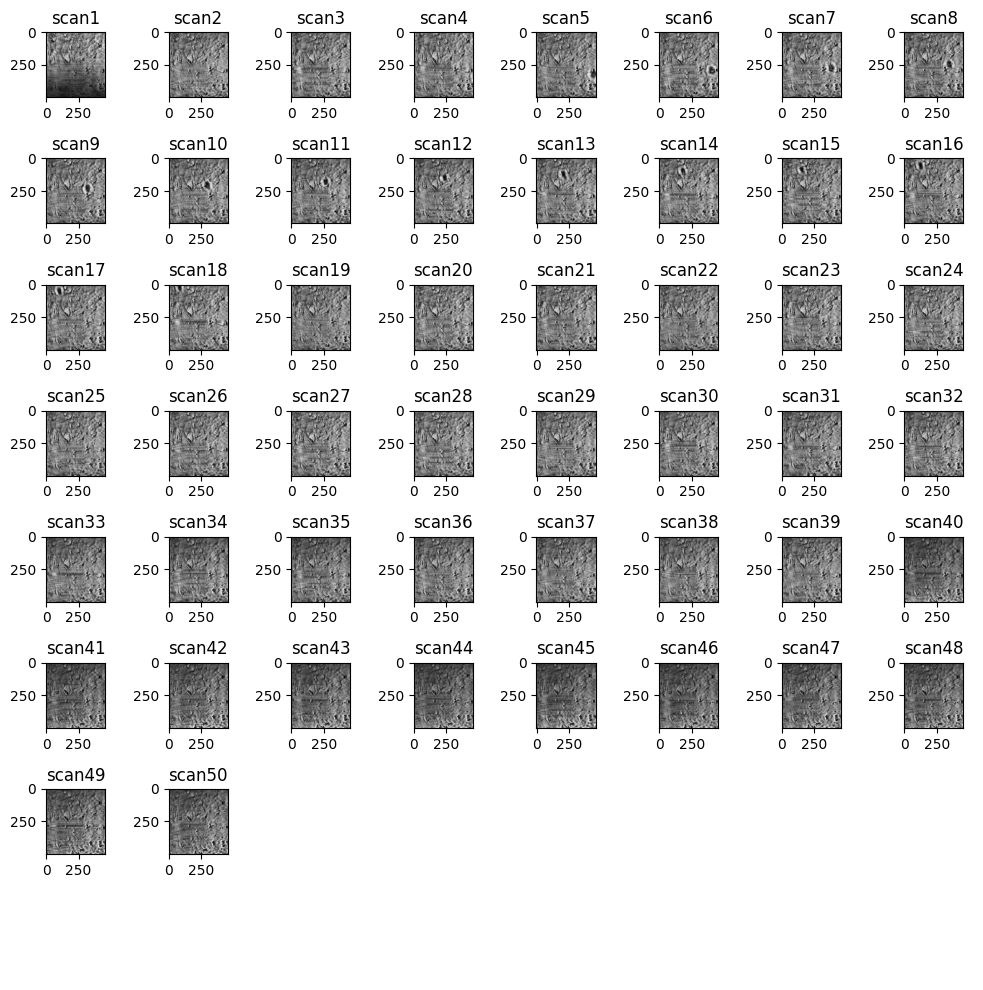

In [27]:
temp_keys = list(datas.keys())

grid_size = int(np.ceil(np.sqrt(len(temp_keys))))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
axes = axes.flatten()

for i,j in enumerate(temp_keys):
    # _,_,mir_UP,mir_DOWN = bottom_extract(datas[j],find_mid(datas[j]))
    axes[i].imshow(equalize_adapthist(min_max(np.mean(datas[j].transpose(1,0,2),axis=0))), cmap='gray')
    axes[i].set_title(temp_keys[i])
    # axes[i].axis('off')  # Turn off axis labels

# If the number of images doesn't perfectly fill the grid, hide extra subplots
for i in range(len(temp_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
# plt.savefig('all_nerves_post_registration.PNG',dpi=500)
plt.show()

In [295]:
path = 'scan17/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 351.91it/s]


In [296]:
n = pics_without_line.shape[1]
mid = find_mid(pics_without_line)
nn = [np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)) for i in range(pics_without_line.shape[0])]
UP, DOWN = np.min(nn)-30,np.max(nn)+30
tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)
    
nn = [np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)) for i in range(pics_without_line.shape[0])]
UP, DOWN = np.min(nn)-30,np.max(nn)+30

tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:07<00:00, 70.86it/s]


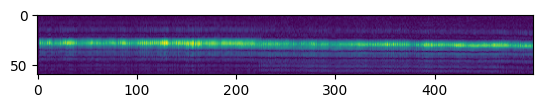

In [297]:
plt.imshow(pics_without_line.transpose(2,1,0)[100][UP:DOWN])

In [298]:
def non_zero_crop(a,b):
    mini = max(np.min(np.where(a[0]!=0)),np.min(np.where(b[0]!=0)))
    maxi = min(np.max(np.where(a[0]!=0)),np.max(np.where(b[0]!=0)))
    return mini, maxi


def denoise_fft(data):
    kk = fftshift(fft2(data))
    filt = np.ones_like(kk)
    filt[(filt.shape[0]//2)-5:(filt.shape[0]//2)+5,(filt.shape[1]//2)-5:(filt.shape[1]//2)+5] = 0
    kk = kk*filt
    kk = np.abs(ifft2(fftshift(kk)))
    return kk

In [299]:
from skimage.metrics import structural_similarity as ssim

In [300]:
def calculate_mad_efficient(data):    
    return np.median(np.abs(data - np.median(data)))

def outlier(data):
    mu  = np.mean(data[:15])
    std = np.std(data[:15])
    x = data[-1]
    if abs(x-mu) > 3*std:
        return True
    return False

In [301]:
# errs = []
# k = 0
# mad = []
# x,y,a,b = bottom_extract(datas['scan10'],find_mid(datas['scan10']))
# for i in (range(5,datas['scan10'].shape[0]-1)):
#     x_zero_offset, y_zero_offset = non_zero_crop(datas['scan10'][i][np.r_[x:y,a:b]],datas['scan10'][i+1][np.r_[x:y,a:b]])
#     temp_e = (2-nmi(min_max(denoise_fft(np.vstack((min_max(datas['scan10'][i][x:y][:,x_zero_offset:y_zero_offset])
#                                                     ,min_max(datas['scan10'][i][a:b][:,x_zero_offset:y_zero_offset])))))
#                     ,min_max(denoise_fft(np.vstack((min_max(datas['scan10'][i+1][x:y][:,x_zero_offset:y_zero_offset])
#                                                     ,min_max(datas['scan10'][i+1][a:b][:,x_zero_offset:y_zero_offset])))))))
#     # if k>15:
#     #     mad.append(outlier(errs[-16:]))
#     # k+=1
#     errs.append(temp_e)
#     # mad.append(calculate_mad_efficient(errs[-10:]))

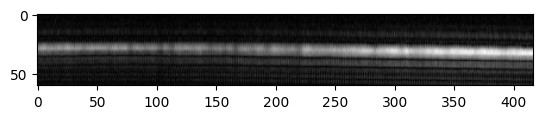

In [302]:
plt.imshow((pics_without_line[2][UP:DOWN]),cmap='gray')

In [303]:
errs = []
# x,y,a,b = bottom_extract(datas['scan10'],find_mid(datas['scan10']))
for i in (range(datas['scan17'].shape[0]-1)):
    temp_e = 1-ncc(min_max(pics_without_line[i][UP:DOWN]),min_max(pics_without_line[i+1][UP:DOWN]))
    errs.append(temp_e[0])
    # mad.append(calculate_mad_efficient(errs[-10:]))

In [304]:
from scipy.signal import find_peaks


In [305]:
AffineTransform(translation=(10,0))

<AffineTransform(matrix=
    [[ 1., -0., 10.],
     [ 0.,  1.,  0.],
     [ 0.,  0.,  1.]]) at 0x1f7657bd0>

In [306]:
np.dot(np.dot(np.eye(3),AffineTransform(translation=(10,0))),AffineTransform(translation=(10,0)))

array([[ 1.,  0., 20.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

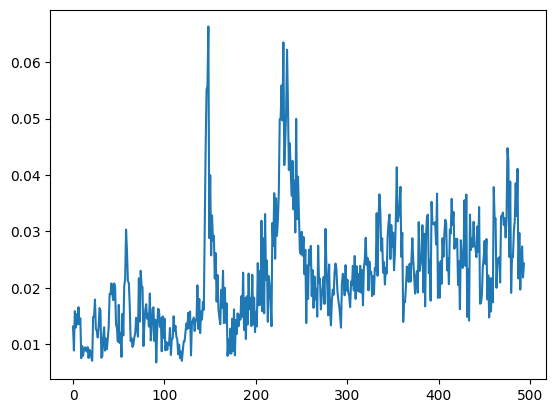

In [307]:
plt.plot(np.array(errs[5:]))

In [308]:

# errs_smooth = np.convolve(np.array(errs).flatten(), np.ones(10)/10)
# plt.plot(errs_smooth[10:-10]**2)

In [309]:
kk = fft(errs[:])
np.argmax(kk[200:300])
kk[20:] = 0
kk = abs(ifft(kk))

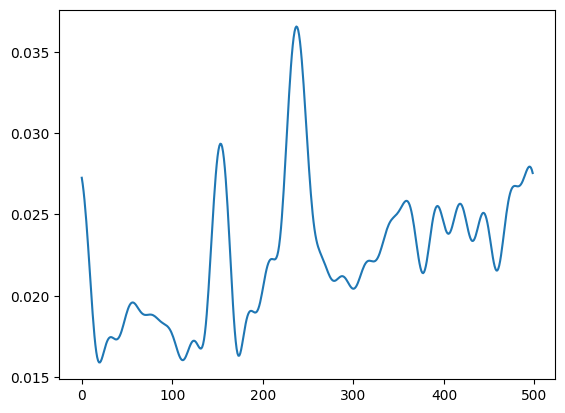

In [310]:
plt.plot(abs(kk))

In [311]:
np.array([143, 164]).shape

(2,)

In [327]:
np.squeeze(np.dstack((np.round(find_peaks(kk,width=5,prominence=0.016)[1]['left_ips']),np.round(find_peaks(kk,width=10,prominence=0.016)[1]['right_ips'])))).reshape(1,-1)

[[225. 250.]]


In [325]:
for k,l in np.squeeze(np.dstack((np.round(find_peaks(kk,width=5,prominence=0.016)[1]['left_ips']),np.round(find_peaks(kk,width=10,prominence=0.016)[1]['right_ips'])))).reshape(1,-1):
    print(k,l)

225.0 250.0


In [314]:
find_peaks(kk,width=10,prominence = 0.016)

(array([237]),
 {'prominences': array([0.0161271]),
  'left_bases': array([20]),
  'right_bases': array([300]),
  'widths': array([25.09425756]),
  'width_heights': array([0.02849468]),
  'left_ips': array([225.06839102]),
  'right_ips': array([250.16264857])})

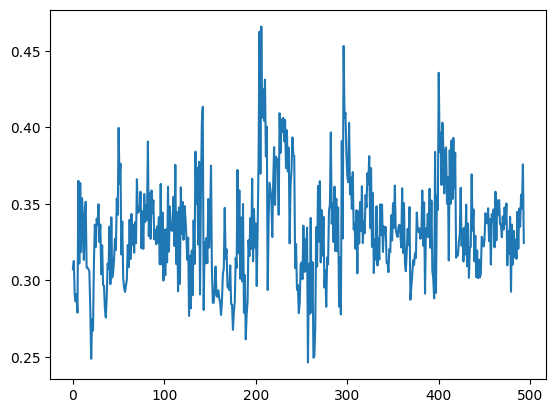

In [177]:
plt.plot(errs)